# Project: Bank Customer Churn (Supervised Learning)

## Introduction

Beta Bank has been losing customers month after month. The bank thinks it'll be cheaper to save existing customers rather than attracting new ones. Using data on its customers' past behavior (including contract termination with the bank), we want to predict whether a customer will leave the bank soon.

Our job will be to build a model with the best possible F1 score (that's at least **0.59**). Our target will be using the `Exited` feature from the available dataset, which is categorical, so we'll be executing a classification task. After looking over the data, we'll test several different models to choose the best one.

## Data Overview

In [1]:
# Load project libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Import the dataset
df_churn = pd.read_csv('datasets/churn.csv')

In [3]:
# Study the data
df_churn.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df_churn.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


The dataset is looking good so far. The column labels and data types don't look to require additional attention.

## Data Preprocessing

### Find missing values

In [6]:
df_churn.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

The only missing values come from the `Tenure` feature. We'll handle them below.

### Find duplicate values

In [7]:
df_churn.duplicated().sum()

0

In [8]:
df_churn['CustomerId'].duplicated().sum()

0

In [9]:
sorted(df_churn['Geography'].unique())

['France', 'Germany', 'Spain']

In [10]:
sorted(df_churn['Gender'].unique())

['Female', 'Male']

There are no duplicate rows, customer ids, geography, nor gender values, so no additional attention seems to be required here.

### Fix data

In [11]:
df_churn_cleaned = df_churn.dropna(subset=['Tenure']).reset_index(drop=True)
df_churn_cleaned = df_churn_cleaned.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1)
df_churn_cleaned = df_churn_cleaned[df_churn_cleaned['Balance'] != 0].reset_index(drop=True)
display(df_churn_cleaned.head(10))
df_churn_cleaned.info()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
1,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
2,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
3,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
4,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
5,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
6,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0
7,528,France,Male,31,6.0,102016.72,2,0,0,80181.12,0
8,616,Germany,Male,45,3.0,143129.41,2,0,1,64327.26,0
9,653,Germany,Male,58,1.0,132602.88,1,1,0,5097.67,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      5808 non-null   int64  
 1   Geography        5808 non-null   object 
 2   Gender           5808 non-null   object 
 3   Age              5808 non-null   int64  
 4   Tenure           5808 non-null   float64
 5   Balance          5808 non-null   float64
 6   NumOfProducts    5808 non-null   int64  
 7   HasCrCard        5808 non-null   int64  
 8   IsActiveMember   5808 non-null   int64  
 9   EstimatedSalary  5808 non-null   float64
 10  Exited           5808 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 499.2+ KB


We apply fixes to the data by dropping the following rows, as it won't serve any benefit to our model evaluations keeping them in:
* Drop rows where `Tenure` is missing a value
* Drop `RowNumber`, `CustomerId`, `Surname` rows
* Drop rows where the customers's bank balance is $0

## Data Analysis

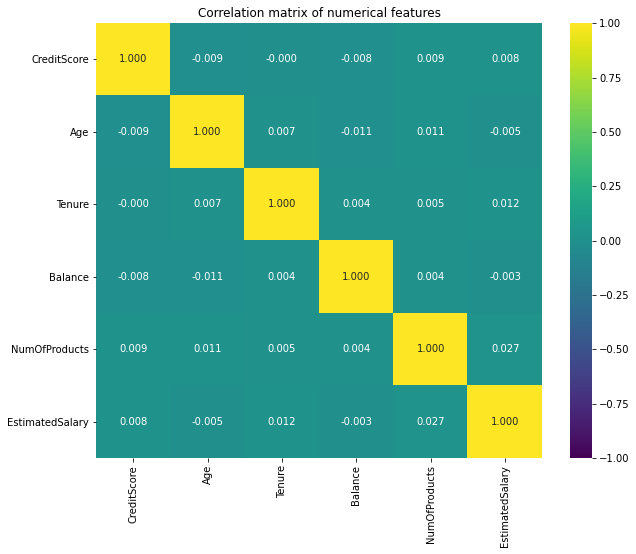

In [12]:
# Plot heatmap of numerical features
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

df_churn_filtered = df_churn_cleaned.filter(items=numeric_features)
corr_matrix = df_churn_filtered.corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix,
    fmt='.3f',
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    cmap='viridis'
)
plt.title('Correlation matrix of numerical features')
plt.show()

We do a quick data analysis on the cleaned dataset, focused on just the numeric features, using a correlation matrix. Overall, correlation seems to be relative non-existent across all the features in question.

## Supervised Learning

### Examine balance of the classes

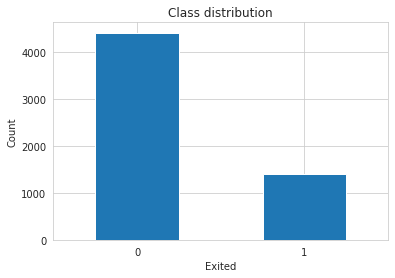

In [13]:
churn_exited = df_churn_cleaned['Exited'].value_counts()

sns.set_style('whitegrid')
churn_exited.plot(kind='bar')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.xticks(rotation='horizontal')
plt.title('Class distribution')
plt.show()

We examine the balance of the `Exited` class via bar plot and see that there is an imbalance right away. This will negatively affect how our models will be trained. We'll need to address the class imbalance below.

### Logistic Regression: Feature prepration

#### Encode features

In [14]:
# One-hot encoding
df_churn_ohe = pd.get_dummies(df_churn_cleaned, columns=['Geography', 'Gender'], drop_first=True)
features_ohe = df_churn_ohe.drop('Exited', axis=1)
target_ohe = df_churn_ohe['Exited']

# Split the data
features_train_ohe, features_remaining_ohe, target_train_ohe, target_remaining_ohe = train_test_split(features_ohe, target_ohe, test_size=0.4, random_state=12345)
features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(features_remaining_ohe, target_remaining_ohe, test_size=0.5, random_state=12345)

# Create and train the model
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train_ohe, target_train_ohe)

# Calculate accuracy
score_train_ohe = model.score(features_train_ohe, target_train_ohe)
score_valid_ohe = model.score(features_valid_ohe, target_valid_ohe)

print(f'Accuracy of the training set: {score_train_ohe}')
print(f'Accuracy of the validation set: {score_valid_ohe}')

Accuracy of the training set: 0.7428243398392652
Accuracy of the validation set: 0.7633390705679862


For our first model, we'll be using **logistic regression**. For this, we need to encode categorical features (`Geography`, `Gender`) into numerical features using One-Hot Encoding. Once that's done, we print the initial accuracy scores for each of the sets that we've split up (using a 3:1:1 ratio).

#### Scale features

In [15]:
# Standardize the data
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric_features])

# Transform the data
features_train_ohe[numeric_features] = scaler.transform(features_train_ohe[numeric_features])
features_valid_ohe[numeric_features] = scaler.transform(features_valid_ohe[numeric_features])
features_test_ohe[numeric_features] = scaler.transform(features_test_ohe[numeric_features])

/tmp/ipykernel_76/1308159269.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_ohe[numeric_features] = scaler.transform(features_train_ohe[numeric_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_76/1308159269.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

Next, we use a scaler to standardize the encoded data since the features have different scales.

### Logistic Regression: Classification metrics

In [16]:
def print_model_evaluation(model, features, target, predictions):
    # F1
    f1 = f1_score(target, predictions)
    
    # Accuracy
    score_valid = model.score(features, target)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(target, predictions)
    sns.heatmap(
        conf_matrix,
        fmt='.0f',
        annot=True,
        cmap='cividis'
    )
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(f'Accuracy score: {score_valid:.3f}')
    plt.plot()

    print(f'F1 score: {f1}')
    print(f'Accuracy score: {score_valid}')
    
    # ROC curve
    probabilities_valid = model.predict_proba(features) # threshold adjustment
    probabilities_one_valid = probabilities_valid[:, 1]
    
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    
    plt.figure()
    plt.plot(fpr, tpr)
    
    # Plot random model ROC curve
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    # Set the boundary for the axes from 0 to 1
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

    # AUC-ROC
    auc_roc = roc_auc_score(target, probabilities_one_valid)
    print(f'AUC-ROC value: {auc_roc}')

For classification metrics, we create a method to evaluate a model (which we will reuse) that provides the following results:
1. F1 score
2. Accuracy store
3. Confusion matrix
4. ROC curve
5. AUC-ROC score

#### Train the model with class imbalance

F1 score: 0.36604774535809015
Accuracy score: 0.7943201376936316


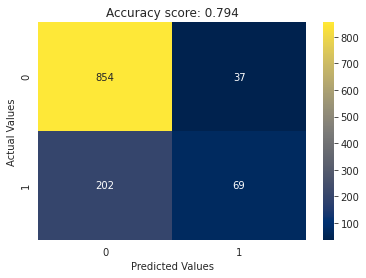

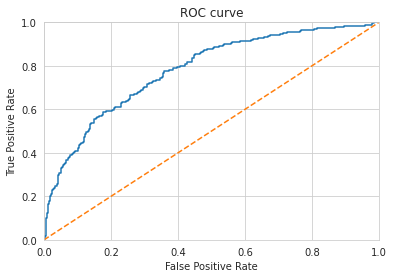

AUC-ROC value: 0.780068002700229


In [17]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train_ohe, target_train_ohe)

# Find predictions
predicted_valid = model.predict(features_valid_ohe)

# Evaluate the model
print_model_evaluation(model, features_valid_ohe, target_valid_ohe, predicted_valid)

For a baseline, we train the model without taking into account the class imbalance. The F1 score using a logistic regression model with the class imbalance intact yields a drastically low score below our target score of **0.59**, which means that both precision and recall are low. We note that the AUC-ROC value is at a decent level.

### Logistic Regression: Fix imbalance of classes

In [18]:
def upsample(features, target, repeat):
    # Split the training sample into negative & positive observations
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [19]:
# Parameter tuning: find best repeat value
features_zeros = features_train_ohe[target_train_ohe == 0]
features_ones = features_train_ohe[target_train_ohe == 1]
target_zeros = target_train_ohe[target_train_ohe == 0]
target_ones = target_train_ohe[target_train_ohe == 1]

best_repeat = None
best_f1 = 0

for repeat in range(1, 11):
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = upsample(features_train_ohe, target_train_ohe, repeat)
    
    # Retrain the model using the new data
    model = LogisticRegression(random_state=12345, solver='liblinear')
    model.fit(features_upsampled, target_upsampled)

    # Find predictions
    predicted_valid = model.predict(features_valid_ohe)

    # Calculate F1 score
    f1 = f1_score(target_valid_ohe, predicted_valid)
    
    print(f'repeat = {repeat} : {f1}')

    if (f1 > best_f1):
        best_repeat = repeat
        best_f1 = f1

print()
print(f'F1 score of the best logistic regression model (using repeat = {best_repeat}) on the training set: {best_f1}')

repeat = 1 : 0.36604774535809015
repeat = 2 : 0.5366726296958856
repeat = 3 : 0.5171428571428571
repeat = 4 : 0.5231143552311435
repeat = 5 : 0.5123258306538049
repeat = 6 : 0.48180924287118976
repeat = 7 : 0.462962962962963
repeat = 8 : 0.45309734513274336
repeat = 9 : 0.4395229982964225
repeat = 10 : 0.4342762063227953

F1 score of the best logistic regression model (using repeat = 2) on the training set: 0.5366726296958856


In [20]:
features_ohe_upsampled, target_ohe_upsampled = upsample(features_train_ohe, target_train_ohe, 2)

In [21]:
def downsample(features, target, fraction):
    # Split the training sample into negative & positive observations
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [22]:
# Parameter tuning: find best fraction value
start = 0.1
end = 1.0
interval = 0.1
best_fraction = None
best_f1 = 0
current = start

while current <= end:
    features_downsampled = pd.concat([features_zeros.sample(frac=current, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=current, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    # Retrain the model using the new data
    model = LogisticRegression(random_state=12345, solver='liblinear')
    model.fit(features_downsampled, target_downsampled)

    # Find predictions
    predicted_valid = model.predict(features_valid_ohe)

    # Calculate F1 score
    f1 = f1_score(target_valid_ohe, predicted_valid)

    print(f'fraction = {current:.1f} : {f1}')

    if (f1 > best_f1):
        best_fraction = current
        best_f1 = f1

    current += interval

print()
print(f'F1 score of the best logistic regression model (using fraction = {best_fraction}) on the training set: {best_f1}')

fraction = 0.1 : 0.4406490179333903
fraction = 0.2 : 0.5156418554476807
fraction = 0.3 : 0.53315649867374
fraction = 0.4 : 0.5403726708074533
fraction = 0.5 : 0.5232974910394266
fraction = 0.6 : 0.4949698189134809
fraction = 0.7 : 0.47161572052401746
fraction = 0.8 : 0.45130641330166277
fraction = 0.9 : 0.4122137404580153
fraction = 1.0 : 0.36604774535809015

F1 score of the best logistic regression model (using fraction = 0.4) on the training set: 0.5403726708074533


In [23]:
features_ohe_downsampled, target_ohe_downsampled = downsample(features_train_ohe, target_train_ohe, 0.4)

Before we continue, we create helper functions to be able to get upsampled and downsampled results easier.

#### Balancing with class weight & upsampling

F1 score: 0.5260196905766525
Accuracy score: 0.7099827882960413


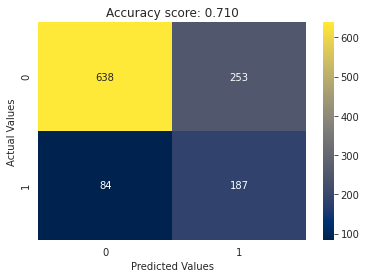

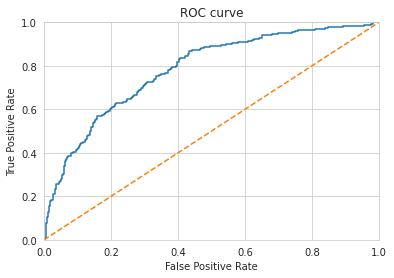

AUC-ROC value: 0.7821387304782138


In [24]:
model = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model.fit(features_ohe_upsampled, target_ohe_upsampled)

# Find predictions
predicted_valid = model.predict(features_valid_ohe)

# Evaluate the model
print_model_evaluation(model, features_valid_ohe, target_valid_ohe, predicted_valid)

Now we being to improve the quality of the model, first by balancing the classes using the `class_weight` parameter and training the model using upsampled data. Both the F1 score and AUC-ROC value have improved, but the F1 score is still below our **0.59** target.

#### Balancing with class weight & downsampling

F1 score: 0.518005540166205
Accuracy score: 0.7005163511187608


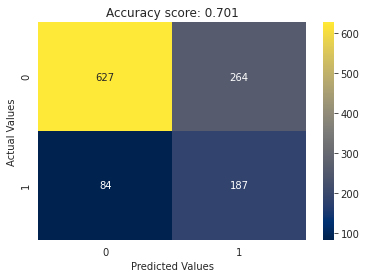

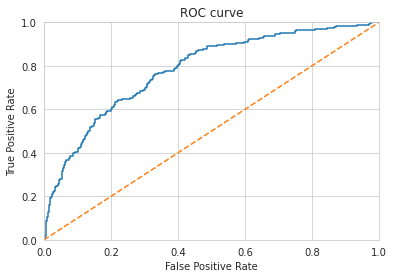

AUC-ROC value: 0.7817494336559527


In [25]:
model = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model.fit(features_ohe_downsampled, target_ohe_downsampled)

# Find predictions
predicted_valid = model.predict(features_valid_ohe)

# Evaluate the model
print_model_evaluation(model, features_valid_ohe, target_valid_ohe, predicted_valid)

We try downsampling next, and see slightly lower performance for the F1 score and AUC-ROC value as compared to the previous upsampling results. We might need to rule out the logistic regression model at this point, as the results are below our target.

### Decision Tree & Random Forest: Feature preparation

#### Encode features

In [26]:
# Transform the data
encoder = OrdinalEncoder()
df_churn_ordinal = pd.DataFrame(encoder.fit_transform(df_churn_cleaned), columns=df_churn_cleaned.columns)
features_ordinal = df_churn_ordinal.drop('Exited', axis=1)
target_ordinal = df_churn_ordinal['Exited']

# Split the data
features_train_ordinal, features_remaining_ordinal, target_train_ordinal, target_remaining_ordinal = train_test_split(features_ordinal, target_ordinal, test_size=0.4, random_state=12345)
features_valid_ordinal, features_test_ordinal, target_valid_ordinal, target_test_ordinal = train_test_split(features_remaining_ordinal, target_remaining_ordinal, test_size=0.5, random_state=12345)

#### Scale features

In [27]:
# Standardize the data
scaler = StandardScaler()
scaler.fit(features_train_ordinal[numeric_features])

# Transform the data
features_train_ordinal[numeric_features] = scaler.transform(features_train_ordinal[numeric_features])
features_valid_ordinal[numeric_features] = scaler.transform(features_valid_ordinal[numeric_features])
features_test_ordinal[numeric_features] = scaler.transform(features_test_ordinal[numeric_features])

/tmp/ipykernel_76/306198331.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_ordinal[numeric_features] = scaler.transform(features_train_ordinal[numeric_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

Moving on, we take care of feature encoding and scaling for both the **decision tree** and **random forest** models, which we'll be using for training next.

For these tree-based algorithms, we need to encode specially using label encoding via an ordinal encoder.

### Decision Tree: Classification metrics

In [28]:
def decision_tree_hyperparameter_tuning(balanced):
    weight = 'balanced' if balanced == True else None
    
    # Find the best F1 score and depth with class imbalance
    best_model = None
    best_f1_score = 0
    best_depth = 0
    
    for depth in range(1, 11):
        # Create the model
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight=weight)
        
        # Train the model
        model.fit(features_train_ordinal, target_train_ordinal)
    
        # Find predictions
        predicted_valid = model.predict(features_valid_ordinal)

        # Calculate F1 score
        f1 = f1_score(target_valid_ordinal, predicted_valid)
    
        # Print quality of training set
        print(f'max_depth = {depth} : {f1}')
    
        if (f1 > best_f1_score):
            best_model = model
            best_f1_score = f1
            best_depth = depth
    
    print()
    print(f'F1 score of the best decision tree model (using max_depth = {best_depth}) on the training set: {best_f1_score}')

We create a helper function to try to determine the best decision tree model by accuracy and max depth that can accommodate whether to account for the `class_weight` paramter or not in training the model. Our `max_depth` range is kept to 10 max, as to avoid overfitting the model.

In [29]:
# Find the best score and depth with class imbalance
decision_tree_hyperparameter_tuning(False)

max_depth = 1 : 0.0
max_depth = 2 : 0.5540540540540541
max_depth = 3 : 0.49350649350649356
max_depth = 4 : 0.5063291139240506
max_depth = 5 : 0.5740740740740741
max_depth = 6 : 0.556745182012848
max_depth = 7 : 0.5458715596330275
max_depth = 8 : 0.567032967032967
max_depth = 9 : 0.5486725663716814
max_depth = 10 : 0.5483870967741935

F1 score of the best decision tree model (using max_depth = 5) on the training set: 0.5740740740740741


In [30]:
# Find the best score and depth with balanced class
decision_tree_hyperparameter_tuning(True)

max_depth = 1 : 0.5216
max_depth = 2 : 0.5643410852713179
max_depth = 3 : 0.5769854132901134
max_depth = 4 : 0.5642737896494157
max_depth = 5 : 0.5403225806451614
max_depth = 6 : 0.5431309904153355
max_depth = 7 : 0.5329512893982808
max_depth = 8 : 0.5415384615384615
max_depth = 9 : 0.5250379362670714
max_depth = 10 : 0.5393939393939393

F1 score of the best decision tree model (using max_depth = 3) on the training set: 0.5769854132901134


### Decision Tree: Fix imbalance of classes

In [31]:
# Parameter tuning: find best repeat value
features_zeros = features_train_ordinal[target_train_ordinal == 0]
features_ones = features_train_ordinal[target_train_ordinal == 1]
target_zeros = target_train_ordinal[target_train_ordinal == 0]
target_ones = target_train_ordinal[target_train_ordinal == 1]

best_repeat = None
best_f1 = 0

for repeat in range(1, 11):
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = upsample(features_train_ordinal, target_train_ordinal, repeat)
    
    # Retrain the model using the new data
    model = DecisionTreeClassifier(random_state=12345, max_depth=3)
    model.fit(features_upsampled, target_upsampled)

    # Find predictions
    predicted_valid = model.predict(features_valid_ordinal)

    # Calculate F1 score
    f1 = f1_score(target_valid_ordinal, predicted_valid)
    
    print(f'repeat = {repeat} : {f1}')

    if (f1 > best_f1):
        best_repeat = repeat
        best_f1 = f1

print()
print(f'F1 score of the best logistic regression model (using repeat = {best_repeat}) on the training set: {best_f1}')

repeat = 1 : 0.49350649350649356
repeat = 2 : 0.5803278688524591
repeat = 3 : 0.5769854132901134
repeat = 4 : 0.5769854132901134
repeat = 5 : 0.4726911618669315
repeat = 6 : 0.4554637281910009
repeat = 7 : 0.4554637281910009
repeat = 8 : 0.4554637281910009
repeat = 9 : 0.4554637281910009
repeat = 10 : 0.4554637281910009

F1 score of the best logistic regression model (using repeat = 2) on the training set: 0.5803278688524591


In [32]:
features_ordinal_upsampled, target_ordinal_upsampled = upsample(features_train_ordinal, target_train_ordinal, 2)

#### Balancing with class weight & upsampling

F1 score: 0.5769854132901134
Accuracy score: 0.7753872633390706


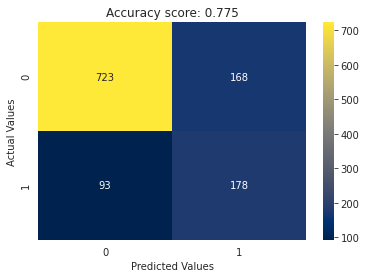

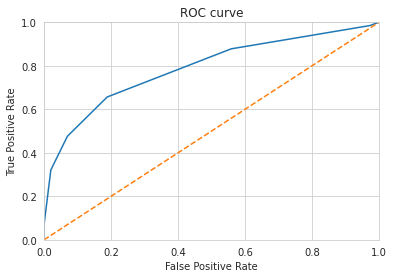

AUC-ROC value: 0.7879015658843456


In [33]:
# Create and train the model
model = DecisionTreeClassifier(random_state=12345, max_depth=3, class_weight='balanced')
model.fit(features_ordinal_upsampled, target_ordinal_upsampled)

# Find predictions
predicted_valid = model.predict(features_valid_ordinal)

# Evaluate the model
print_model_evaluation(model, features_valid_ordinal, target_valid_ordinal, predicted_valid)

Using the decision tree model, we balance the classes using the `class_weight` parameter and train the model using upsampled data. Our results are a small improvement over our previous logistic regression models.

In [34]:
# Parameter tuning: find best fraction value
start = 0.1
end = 1.0
interval = 0.1
best_fraction = None
best_f1 = 0
current = start

while current <= end:
    features_downsampled = pd.concat([features_zeros.sample(frac=current, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=current, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    # Retrain the model using the new data
    model = DecisionTreeClassifier(random_state=12345, max_depth=3)
    model.fit(features_downsampled, target_downsampled)

    # Find predictions
    predicted_valid = model.predict(features_valid_ordinal)

    # Calculate F1 score
    f1 = f1_score(target_valid_ordinal, predicted_valid)

    print(f'fraction = {current:.1f} : {f1}')

    if (f1 > best_f1):
        best_fraction = current
        best_f1 = f1

    current += interval

print()
print(f'F1 score of the best decision tree model (using fraction = {best_fraction}) on the training set: {best_f1}')

fraction = 0.1 : 0.4745762711864407
fraction = 0.2 : 0.4752275025278059
fraction = 0.3 : 0.5823223570190641
fraction = 0.4 : 0.5823223570190641
fraction = 0.5 : 0.5823223570190641
fraction = 0.6 : 0.5677655677655677
fraction = 0.7 : 0.5824561403508772
fraction = 0.8 : 0.5777777777777778
fraction = 0.9 : 0.5025906735751295
fraction = 1.0 : 0.49350649350649356

F1 score of the best decision tree model (using fraction = 0.7) on the training set: 0.5824561403508772


In [35]:
features_ordinal_downsampled, target_ordinal_downsampled = downsample(features_train_ordinal, target_train_ordinal, 0.7)

#### Balancing with class weight & downsampling

F1 score: 0.5406824146981627
Accuracy score: 0.6987951807228916


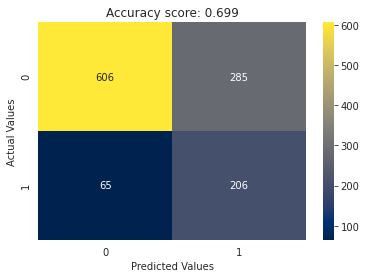

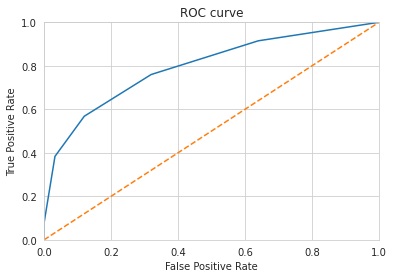

AUC-ROC value: 0.794830221029483


In [36]:
# Create and train the model
model = DecisionTreeClassifier(random_state=12345, max_depth=3, class_weight='balanced')
model.fit(features_ordinal_downsampled, target_ordinal_downsampled)

# Find predictions
predicted_valid = model.predict(features_valid_ordinal)

# Evaluate the model
print_model_evaluation(model, features_valid_ordinal, target_valid_ordinal, predicted_valid)

We try downsampling next, but don't see an improvement with the F1 score (although the AUC-ROC value has slightly improved over the upsampling results). We move onto random forest next to see if it can do better than the previous two regression models.

### Random Forest: Classification metrics

In [37]:
def random_forest_hyperparameter_tuning(balanced):
    weight = 'balanced' if balanced == True else None

    best_f1_score = 0
    best_est = 0
    best_depth = 0
    
    for est in range(10, 101, 10):
        for depth in range(1, 11):
            # Create the model
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight=weight)
            
            # Train the model
            model.fit(features_train_ordinal, target_train_ordinal)

            # Find predictions
            predicted_valid = model.predict(features_valid_ordinal)
        
            # Calculate F1 score
            f1 = f1_score(target_valid_ordinal, predicted_valid)
        
            # Print quality of training set
            print(f'n_estimators = {est}, max_depth = {depth} : {f1}')
        
            if f1 > best_f1_score:
                best_f1_score = f1
                best_est = est
                best_depth = depth
    
    print()
    print(f'F1 score of the best random forest model using n_estimators = {best_est} and max_depth = {depth} on the validation set: {best_f1_score}')

As with the decision tree model, we create a helper function to try to determine the best random forest model by accuracy, number of estimators, and max depth, which can also accommodate whether to account for the `class_weight` paramter or not in training the model.

In [38]:
# Find the best score, number of estimators, and depth with class imbalance
random_forest_hyperparameter_tuning(False)

n_estimators = 10, max_depth = 1 : 0.09154929577464789
n_estimators = 10, max_depth = 2 : 0.1501706484641638
n_estimators = 10, max_depth = 3 : 0.3609467455621302
n_estimators = 10, max_depth = 4 : 0.5177664974619289
n_estimators = 10, max_depth = 5 : 0.5427872860635696
n_estimators = 10, max_depth = 6 : 0.5289672544080605
n_estimators = 10, max_depth = 7 : 0.5278450363196125
n_estimators = 10, max_depth = 8 : 0.5539906103286385
n_estimators = 10, max_depth = 9 : 0.5437352245862884
n_estimators = 10, max_depth = 10 : 0.5520361990950226
n_estimators = 20, max_depth = 1 : 0.036231884057971016
n_estimators = 20, max_depth = 2 : 0.22875816993464052
n_estimators = 20, max_depth = 3 : 0.4273504273504274
n_estimators = 20, max_depth = 4 : 0.43287671232876707
n_estimators = 20, max_depth = 5 : 0.5297029702970296
n_estimators = 20, max_depth = 6 : 0.545
n_estimators = 20, max_depth = 7 : 0.5333333333333333
n_estimators = 20, max_depth = 8 : 0.5609756097560976
n_estimators = 20, max_depth = 9 : 

In [39]:
# Find the best score, number of estimators, and depth with balanced class
random_forest_hyperparameter_tuning(True)

n_estimators = 10, max_depth = 1 : 0.5696594427244581
n_estimators = 10, max_depth = 2 : 0.5429292929292929
n_estimators = 10, max_depth = 3 : 0.5876623376623377
n_estimators = 10, max_depth = 4 : 0.5779816513761468
n_estimators = 10, max_depth = 5 : 0.5876623376623377
n_estimators = 10, max_depth = 6 : 0.5996810207336523
n_estimators = 10, max_depth = 7 : 0.6125211505922166
n_estimators = 10, max_depth = 8 : 0.5849387040280211
n_estimators = 10, max_depth = 9 : 0.5974499089253188
n_estimators = 10, max_depth = 10 : 0.58364312267658
n_estimators = 20, max_depth = 1 : 0.5683563748079877
n_estimators = 20, max_depth = 2 : 0.5745341614906833
n_estimators = 20, max_depth = 3 : 0.5886075949367089
n_estimators = 20, max_depth = 4 : 0.5871271585557299
n_estimators = 20, max_depth = 5 : 0.5895765472312703
n_estimators = 20, max_depth = 6 : 0.5983739837398374
n_estimators = 20, max_depth = 7 : 0.5960264900662251
n_estimators = 20, max_depth = 8 : 0.5974955277280859
n_estimators = 20, max_depth 

### Random Forest: Fix imbalance of classes

In [40]:
# Parameter tuning: find best repeat value
features_zeros = features_train_ordinal[target_train_ordinal == 0]
features_ones = features_train_ordinal[target_train_ordinal == 1]
target_zeros = target_train_ordinal[target_train_ordinal == 0]
target_ones = target_train_ordinal[target_train_ordinal == 1]

best_repeat = None
best_f1 = 0

for repeat in range(1, 11):
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = upsample(features_train_ordinal, target_train_ordinal, repeat)
    
    # Retrain the model using the new data
    model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=10)
    model.fit(features_upsampled, target_upsampled)

    # Find predictions
    predicted_valid = model.predict(features_valid_ordinal)

    # Calculate F1 score
    f1 = f1_score(target_valid_ordinal, predicted_valid)
    
    print(f'repeat = {repeat} : {f1}')

    if (f1 > best_f1):
        best_repeat = repeat
        best_f1 = f1

print()
print(f'F1 score of the best logistic regression model (using repeat = {best_repeat}) on the training set: {best_f1}')

repeat = 1 : 0.5761904761904763
repeat = 2 : 0.61010101010101
repeat = 3 : 0.6308243727598566
repeat = 4 : 0.6074313408723748
repeat = 5 : 0.6020864381520119
repeat = 6 : 0.5870786516853933
repeat = 7 : 0.5790884718498659
repeat = 8 : 0.5641025641025641
repeat = 9 : 0.548148148148148
repeat = 10 : 0.5504807692307693

F1 score of the best logistic regression model (using repeat = 3) on the training set: 0.6308243727598566


In [41]:
features_ordinal_upsampled, target_ordinal_upsampled = upsample(features_train_ordinal, target_train_ordinal, 3)

In [42]:
# Parameter tuning: find best fraction value
start = 0.1
end = 1.0
interval = 0.1
best_fraction = None
best_f1 = 0
current = start

while current <= end:
    features_downsampled = pd.concat([features_zeros.sample(frac=current, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=current, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    # Retrain the model using the new data
    model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=10)
    model.fit(features_downsampled, target_downsampled)

    # Find predictions
    predicted_valid = model.predict(features_valid_ordinal)

    # Calculate F1 score
    f1 = f1_score(target_valid_ordinal, predicted_valid)
    
    # f1 = accuracy_score(target_train_ohe, predicted_train)

    print(f'fraction = {current:.1f} : {f1}')

    if (f1 > best_f1):
        best_fraction = current
        best_f1 = f1

    current += interval

print()
print(f'F1 score of the best decision tree model (using fraction = {best_fraction}) on the training set: {best_f1}')

fraction = 0.1 : 0.44027303754266206
fraction = 0.2 : 0.549346016646849
fraction = 0.3 : 0.6014388489208633
fraction = 0.4 : 0.6085526315789473
fraction = 0.5 : 0.6038461538461538
fraction = 0.6 : 0.6157024793388429
fraction = 0.7 : 0.5965665236051502
fraction = 0.8 : 0.5869074492099323
fraction = 0.9 : 0.5767441860465117
fraction = 1.0 : 0.5645933014354068

F1 score of the best decision tree model (using fraction = 0.6) on the training set: 0.6157024793388429


In [43]:
features_ordinal_downsampled, target_ordinal_downsampled = downsample(features_train_ordinal, target_train_ordinal, 0.6)

#### Balancing with class weight & upsampling

F1 score: 0.6071428571428572
Accuracy score: 0.810671256454389


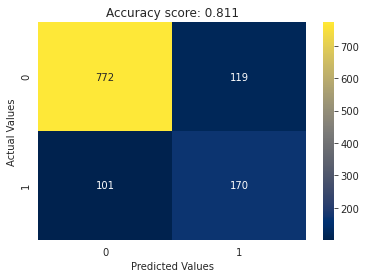

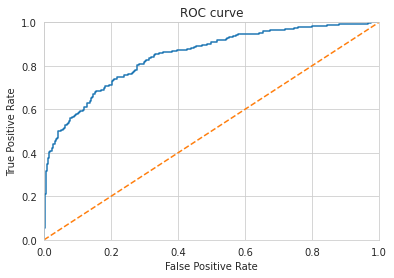

AUC-ROC value: 0.846799276073569


In [44]:
# Create and train the model
model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=10, class_weight='balanced')
model.fit(features_ordinal_upsampled, target_ordinal_upsampled)

# Find predictions
predicted_valid = model.predict(features_valid_ordinal)

# Evaluate the model
print_model_evaluation(model, features_valid_ordinal, target_valid_ordinal, predicted_valid)

Using the random forest model, we balance the classes using the `class_weight` parameter and train the model using upsampled data. Our F1 score is finally above our target, and the AUC-ROC value has improved as well.

#### Balancing with class weight & downsampling

F1 score: 0.622540250447227
Accuracy score: 0.8184165232358004


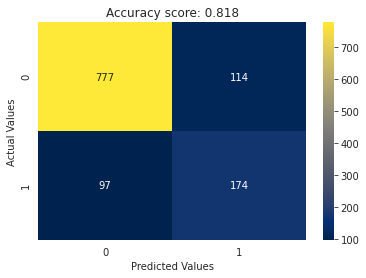

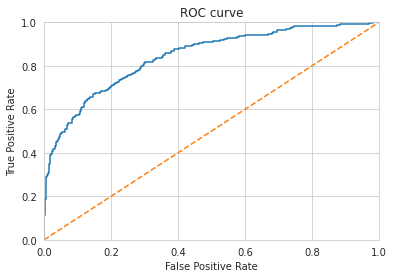

AUC-ROC value: 0.8429684296842967


In [45]:
# Create and train the model
model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=10, class_weight='balanced')
model.fit(features_ordinal_downsampled, target_ordinal_downsampled)

# Find predictions
predicted_valid = model.predict(features_valid_ordinal)

# Evaluate the model
print_model_evaluation(model, features_valid_ordinal, target_valid_ordinal, predicted_valid)

We try downsampling next, and see an F1 score a little higher than the upsampling result (although the AUC-ROC value has slightly decreased from the upsampling results). This will be our candidate for the best model to date.

### Final testing

#### Pick the best model

F1 score: 0.622540250447227
Accuracy score: 0.8184165232358004


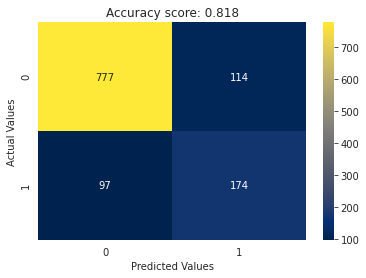

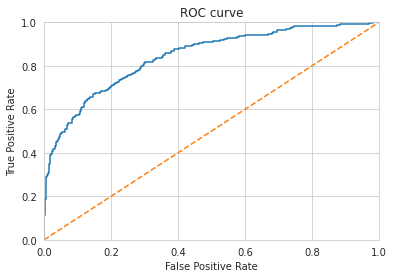

AUC-ROC value: 0.8429684296842967


In [46]:
# Create and train the model
model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=10, class_weight='balanced')
model.fit(features_ordinal_downsampled, target_ordinal_downsampled)

# Find predictions
predicted_valid = model.predict(features_valid_ordinal)

# Evaluate the model
print_model_evaluation(model, features_valid_ordinal, target_valid_ordinal, predicted_valid)

Here we revisit the best model that we previously identified, using the random tree regression and class balancing using the `class_weight` paramter and upsampled model training. These conditions yield around a `0.62` F1 score, which is a few decimals above the **0.59** target!

#### Check F1 for the test set

F1 score: 0.6225402504472272
Accuracy score: 0.8184165232358004


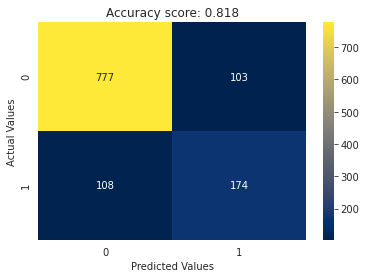

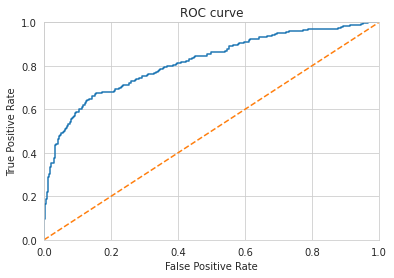

AUC-ROC value: 0.815884912959381


In [48]:
# Create and train the model
model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=10, class_weight='balanced')
model.fit(features_ordinal_downsampled, target_ordinal_downsampled)

# Find predictions
predicted_test = model.predict(features_test_ordinal)

# Evaluate the model
print_model_evaluation(model, features_test_ordinal, target_test_ordinal, predicted_test)

We check our F1 score using the test set to get a sense of our best random forest model's general performance. The test set's results come up quite close to our best model's, confirming that it's the choice we want to go with.

## Conclusion

We conclude that a random forest regression model with balanced classes using a class weight adjustment and downsampled data is the best model for predicting whether a customer is going to leave the bank or not. Our model's highest F1 score was around `0.62`, with a AUC-ROC value of **0.85**.

We did this by training logistic regression, deicision tree, and random forest models models in succession. For all three, we used the class weight parameter adjustment in conjunction with upsampled and downsampled data, respectively, as well as tuning for the best parameters to use in addressing class imbalance and improving our models.